In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from casacore.tables import table

import glob
import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units

import katdal 
import katpoint
from scikits.fitting import ScatterFit, GaussianFit

from ska_sdp_datamodels.visibility import create_visibility_from_ms

from ska_sdp_func_python.calibration import solve_gaintable 
from ska_sdp_func_python.util.coordinate_support import ecef_to_lla

In [2]:
# Beam fitting routine
def _fwhm_to_sigma(fwhm):
    """
    Standard deviation of Gaussian function with specified
    FWHM beamwidth.

    :param fwhm: Full-width half-maximum (FWHM) beamwidth
    :return: The standard deviation of a Gaussian beam pattern
    with a specified full-width half-maximum (FWHM) beamwidth.
    This beamwidth is the width between the two points left and
    right of the peak where the Gaussian function attains half
    its maximum value
    """
    # Gaussian function reaches half its peak value at sqrt(2 log 2)*sigma
    return fwhm / 2.0 / np.sqrt(2.0 * np.log(2.0))


def _sigma_to_fwhm(sigma):
    """
    FWHM beamwidth of Gaussian function with specified standard
    deviation.

    :param sigma: The standard deviation of a Gaussian beam pattern
    with a specified full-width half-maximum (FWHM) beamwidth
    :return: The full-width half-maximum (FWHM) beamwidth of a Gaussian
    beam pattern with a specified standard deviation. This beamwidth
    is the width between the two points left and right of the peak
    where the Gaussian function attains half its maximum value
    """
    # Gaussian function reaches half its peak value at sqrt(2 log 2)*sigma
    return 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma

class BeamPatternFit(ScatterFit):
    """
    Fit analytic beam pattern to total power data defined on
    2-D plane. This fits a two-dimensional Gaussian curve (with
    diagonal covariance matrix) to total power data as a function
    of 2-D coordinates. The Gaussian bump represents an antenna
    beam pattern convolved with a point source.

    :param centre: Initial guess of 2-element beam centre, in target
        coordinate units
    :param width: Initial guess of single beam width for both dimensions,
        or 2-element beam width vector, expressed as FWHM in units of
        target coordinates
    :param height: Initial guess of beam pattern amplitude or height

    Attributes
    ----------
    expected_width: real array, shape (2,), or float
        Initial guess of beamwidth, saved as expected width for checks
    is_valid : bool
        True if beam parameters are within reasonable ranges after fit
    std_centre: array of float, shape (2,)
        Standard error of beam centre, only set after :func:`fit`
    std_width: array of float, shape (2,), or float
        Standard error of beamwidth(s), only set after :func:`fit`
    std_height: float
        Standard error of beam height, only set after :func:`fit`
    """

    def __init__(self, centre, width, height):
        super().__init__()
        if not np.isscalar(width):
            width = np.atleast_1d(width)
        self._interp = GaussianFit(centre, _fwhm_to_sigma(width), height)
        self.centre = self._interp.mean
        self.width = _sigma_to_fwhm(self._interp.std)
        self.height = self._interp.height
        self.expected_width = width
        self.is_valid = False
        self.std_centre = self.std_width = self.std_height = None

    def fit(self, x, y, std_y=1.0, thresh_width=1.25):
        """
        Fit a beam pattern to data.
        The centre, width and height of the fitted beam pattern
        (and their standard errors) can be obtained from the
        corresponding member variables after this is run.

        :param x: Sequence of (2, N) target coordinates (as column vectors)
        :param y: Sequence of (N, ) corresponding total power values to fit
        :param std_y: Optional measurement error or uncertainty of (N, ) `y`
            values, expressed as standard deviation in units of `y`.
        :param thresh_width: The maximum ratio of the fitted to expected
            beamwidth
        :return: The fitted beam parameters (centre, width, height and their
            uncertainties)
        """
        self._interp.fit(x, y, std_y)
        self.centre = self._interp.mean
        self.width = _sigma_to_fwhm(self._interp.std)
        self.height = self._interp.height
        self.std_centre = self._interp.std_mean
        self.std_width = _sigma_to_fwhm(self._interp.std_std)
        self.std_height = self._interp.std_height
        self.is_valid = not any(np.isnan(self.centre)) and self.height > 0.0

        # Validation of the fitted beam using SNR and the size of the
        # fitted width compared to the expected. The fitted beam can
        # only be equal to the expected or greater than the expected
        # by less than thresh_width
        
        fit_snr = self._interp.std / self._interp.std_std
        norm_width = self.width / self.expected_width

        self.is_valid = not any(np.isnan(self.centre)) and self.height > 0.
        fit_snr = self._interp.std / self._interp.std_std
        norm_width = self.width / self.expected_width
        
        self.is_valid &= all(norm_width > 0.9) and all(norm_width < thresh_width) #and all(fit_snr) > 0.
           

In [3]:
def construct_antennas(xyz, diameter, station):
    """
    Construct list of katpoint antenna objects
    based on telescope configuration information.

    :param xyz: xyz coordinates of antenna positions in [nants, 3]
    :param diameter: Diameter of dishes in [nants]
    :param station: List of the antenna names [nants]
    :return: a set of katpoint.Antenna objects
    """
    latitude, longitude, altitude = ecef_to_lla(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2])

    ants = []
    for ant_name, diam, lat, long, alt in zip(
        station, diameter, latitude, longitude, altitude
    ):
        # Antenna information
        # The beamwidth is HPBW of an antenna: k * lambda/D
        # We use an estimate of k=1.22 but not used in
        # calculating the beamwidth as k is passed from
        # the command line. The "beamwidth" as used in ant is
        # actually referring to the beamwidth factor, k.
        ant = katpoint.Antenna(
            name=ant_name,
            latitude=lat,
            longitude=long,
            altitude=alt,
            diameter=diam,
            delay_model=None,
            pointing_model=None,
            beamwidth=1.22,
        )
        ants.append(ant)

    return ants

In [4]:
# Set your parameters 
num_chunks = 4
thresh_width = 1.25
beamwidth_factor = (0.976, 1.098)
fit_on_plane = False # False implies using the relative azel for the fitting

In [5]:
msfiles = sorted(glob.glob("/mnt/storage-main/main/ska/meerkat/no_cal_applied/split_into_scans/16*.ms/"))
#print(msfiles)

# # Read the DIRECTION column of the SOURCE table. They should be the same
# but this isn't the case for our simulations. Use first MS for now
#ra, dec = table(msfiles[0]+"::SOURCE", ack=False).getcol("DIRECTION")[0]
#print(np.degrees(ra), np.degrees(dec))
ra = 295.35
dec = -30.0
ra = ra * np.pi/180.
dec = dec * np.pi/180.
target = katpoint.construct_radec_target(ra=ra, dec=dec)
#print(target)

# Construct katpoint antennas
ant_pos = table(msfiles[0]+"::ANTENNA", ack=False).getcol("POSITION")
ant_diameter = table(msfiles[0]+"::ANTENNA", ack=False).getcol("DISH_DIAMETER")
ant_name = table(msfiles[0]+"::ANTENNA", ack=False).getcol("NAME")
ants = construct_antennas(xyz=ant_pos, diameter=ant_diameter, station=ant_name)

x_per_scan = np.zeros((len(msfiles), len(ants), 2))
timestamps = [ ]
for i in range(len(msfiles)):
    # Read the POINTING table
    ms = msfiles[i]
    pointing_table = table(ms+"::POINTING", ack=False)
    pointing_times = pointing_table.getcol("TIME")
    requested_azel = pointing_table.getcol("TARGET")
    actual_azel = pointing_table.getcol("DIRECTION")
    
    # Average in time 
    requested_azel = requested_azel.mean(axis=0)
    actual_azel = actual_azel.mean(axis=0)
    timestamps.append(pointing_times)
    
    for j,antenna in enumerate(ants): 
        if fit_on_plane: 
            # Option 1: Projecting onto a plane doesn't work - invalid fits for all antennas
            xy = target.sphere_to_plane(az=np.radians(requested_azel[j,0]), 
                                       el=np.radians(requested_azel[j,1]),
                                       timestamp=np.median(pointing_times),
                                       antenna=antenna,
                                       projection_type="ARC", 
                                       coord_system="azel") 
            x_per_scan[i] = np.degrees(np.array(xy))
        else:                                              
            # Option 2: Construct AstroPy Coord and compute relative azel
            target_azel = np.degrees(target.azel(timestamp=np.median(pointing_times), antenna=antenna)) 
            target_coord = SkyCoord(target_azel[0]*units.deg, target_azel[1]*units.deg, frame="icrs")
            requested_coord = SkyCoord(requested_azel[j, 0]*units.deg, requested_azel[j, 1]*units.deg, frame="icrs")
            actual_coord = SkyCoord(actual_azel[j, 0]*units.deg, actual_azel[j, 1]*units.deg, frame="icrs")

            dra, ddec = target_coord.spherical_offsets_to(requested_coord)
            dra = dra.deg 
            ddec = ddec.deg
            relative_azel = np.r_[dra, ddec]
            x_per_scan[i] = relative_azel 
  

RuntimeError: Table DataManager error: Invalid operation: ISM: no array in row 0 in column TARGET of /mnt/storage-main/main/ska/meerkat/no_cal_applied/split_into_scans/1672727931_sdp_l0_scan_1.ms/POINTING/table.f0

In [6]:
freqs = table(msfiles[0]+"::SPECTRAL_WINDOW", ack=False).getcol("CHAN_FREQ")[0]
channels = np.arange(len(freqs)).reshape(num_chunks, -1)
freqs = freqs.reshape(num_chunks, -1).mean(axis=1)
#print(freqs.shape, channels.shape)

if num_chunks:
    y_per_scan = np.zeros((len(msfiles), len(ants), num_chunks))
else:
    y_per_scan = np.zeros((len(msfiles), len(ants)))
    
for i in range(len(msfiles)):
    ms = msfiles[i]
    for j,chan in enumerate(channels): 
        start_chan = chan[0]
        end_chan = chan[-1]
        #print(start_chan, end_chan)
        vis = create_visibility_from_ms(msname=ms, 
                                        start_chan=start_chan, 
                                        end_chan=end_chan, 
                                        ack=False, 
                                        datacolumn="DATA", 
                                        average_channels=False)
        
        print(f"Solving for G terms in Band {j+1} (channels {start_chan+1} - {end_chan+1})")
        gt = solve_gaintable(vis=vis[0], 
                            modelvis=None,
                            gain_table=None,
                            phase_only=False, 
                            niter=200, 
                            tol=1e-6,
                            crosspol=False, 
                            normalise_gains=None, 
                            jones_type="G", 
                            timeslice=None)
        gt_amp = np.abs(gt.gain.data)
        gt_amp = np.dstack((gt_amp[:, :, :, 0, 0], gt_amp[:, :, :, 1, 1]))
        gt_amp = gt_amp[0,].mean(axis=1)
        y_per_scan[i, :, j] = gt_amp
    
y_per_scan = np.moveaxis(y_per_scan, 0, 2)   
print(f"\nx-parameter: {x_per_scan.shape}")
print(f"y-parameter: {y_per_scan.shape}")
print(f"Number of frequencies: {len(freqs)}")

Solving for G terms in Band 1 (channels 1 - 8)
Solving for G terms in Band 2 (channels 9 - 16)
Solving for G terms in Band 3 (channels 17 - 24)
Solving for G terms in Band 4 (channels 25 - 32)
Solving for G terms in Band 1 (channels 1 - 8)
Solving for G terms in Band 2 (channels 9 - 16)
Solving for G terms in Band 3 (channels 17 - 24)
Solving for G terms in Band 4 (channels 25 - 32)
Solving for G terms in Band 1 (channels 1 - 8)
Solving for G terms in Band 2 (channels 9 - 16)
Solving for G terms in Band 3 (channels 17 - 24)
Solving for G terms in Band 4 (channels 25 - 32)
Solving for G terms in Band 1 (channels 1 - 8)
Solving for G terms in Band 2 (channels 9 - 16)
Solving for G terms in Band 3 (channels 17 - 24)
Solving for G terms in Band 4 (channels 25 - 32)
Solving for G terms in Band 1 (channels 1 - 8)
Solving for G terms in Band 2 (channels 9 - 16)
Solving for G terms in Band 3 (channels 17 - 24)
Solving for G terms in Band 4 (channels 25 - 32)

x-parameter: (5, 4, 2)
y-parameter

Text(0, 0.5, 'Un-normalised G amplitude')

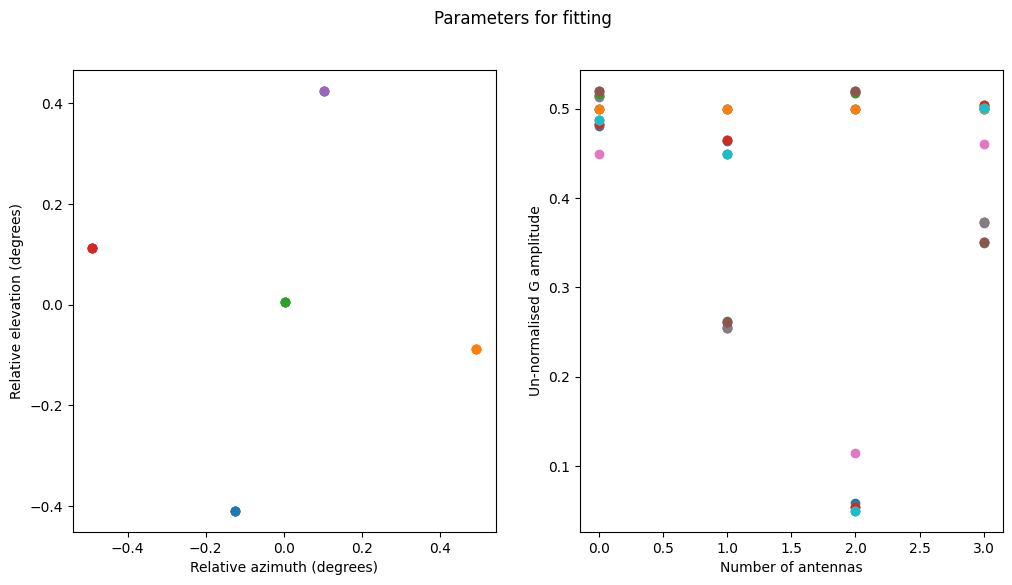

In [7]:
plt.figure(figsize=(12, 6))
plt.suptitle("Parameters for fitting")
for i in range(len(msfiles)):
    plt.subplot(121)
    plt.plot(x_per_scan[i, :, 0], x_per_scan[i, :, 1], "o")
    plt.xlabel("Relative azimuth (degrees)")
    plt.ylabel("Relative elevation (degrees)")
    
    plt.subplot(122)
    plt.plot(y_per_scan[:, :, i], "o")
plt.xlabel("Number of antennas")
plt.ylabel("Un-normalised G amplitude")

In [8]:
# For each antenna, we fit the beams to the gains in each usable num_chunk
# So for each scan, we get solutions for each num_chunk 
beams = {} # for collecting the fitted beam solutions 

for i, antenna in enumerate(ants):
    x_param = x_per_scan[:, i].T
    for chunk in range(num_chunks):
        print(f"Fitting beams to {antenna.name} in Band {chunk+1}")
        y_param = y_per_scan[i, chunk] 
        #print(x_param.shape, y_param.shape)

        # Compute the expected beamwidth
        wavelength = katpoint.lightspeed / freqs[chunk] 
        expected_width = np.sqrt(2)*np.degrees(np.array(beamwidth_factor)*wavelength/antenna.diameter)

        # Begin fitting 
        fitted_beam = BeamPatternFit(centre=(0.,0.), 
                                     width=expected_width, 
                                     height=1.0)
        fitted_beam.fit(x_param, 
                        y_param, 
                        std_y=1.0, 
                        thresh_width=thresh_width) 
        print(antenna.name)
        print(f"Fitted centre: {fitted_beam.centre}")
        print(f"Expected width: {fitted_beam.expected_width}")
        print(f"Fitted width: {fitted_beam.width}")
        print(f"Thresh_width: {fitted_beam.width / fitted_beam.expected_width}")
        print("="*30)
        
        # Collect the fitted beams
        beams_freq = beams.get(antenna.name, [None] * num_chunks)
        beams_freq[chunk] = fitted_beam
        beams[antenna.name] = beams_freq 
            

Fitting beams to SKA001 in Band 1
SKA001
Fitted centre: [-3.84035947e+02 -5.98318454e-02]
Expected width: [1.20367938 1.35413931]
Fitted width: [302.34717099   2.2469406 ]
Thresh_width: [251.18580175   1.65931274]
Fitting beams to SKA001 in Band 2
SKA001
Fitted centre: [-6.84096894e+02  2.82620158e-02]
Expected width: [1.17679404 1.32389329]
Fitted width: [660.31197151   3.01208466]
Thresh_width: [561.11090893   2.27517178]
Fitting beams to SKA001 in Band 3
SKA001
Fitted centre: [-7.04268662e+02  2.82650509e-02]
Expected width: [1.15108347 1.2949689 ]
Fitted width: [670.14437508   3.01208536]
Thresh_width: [582.18573392   2.3259905 ]
Fitting beams to SKA001 in Band 4
SKA001
Fitted centre: [-6.94832265e+02  2.82674851e-02]
Expected width: [1.12647233 1.26728137]
Fitted width: [665.49748862   3.01208151]
Thresh_width: [590.78014602   2.37680564]
Fitting beams to SKA036 in Band 1
SKA036
Fitted centre: [-0.00582408 -0.06653395]
Expected width: [1.20367938 1.35413931]
Fitted width: [1.01387

In [9]:
# Get all your valid fits and perform a weighted average of the computed offsets 
azel_offset = np.full((len(ants), 2), np.nan)
for i, antenna in enumerate(ants):
    beams_freq = beams.get(antenna.name, [])
 
    beams_freq = [b for b in beams_freq if b is not None and b.is_valid]
    if not beams_freq: 
        print(f"{antenna.name} had no valid primary beam fitted")
        continue
    offsets_freq = np.array([b.centre for b in beams_freq])
    offsets_freq_std = np.array([b.std_centre for b in beams_freq])
    weights_freq = 1. / offsets_freq_std ** 2

    # Do weighted average of offsets over frequency chunks
    results = np.average(offsets_freq, axis=0, weights=weights_freq, returned=True)
    pointing_offset = results[0]
    pointing_offset_std = np.sqrt(1. / results[1])
    
    if fit_on_plane:
        # De-project back to azel 
        beam_centre_azel = target.plane_to_sphere(*pointing_offset, 
                                                  timestamp=np.median(timestamps),
                                                  antenna=antenna, 
                                                  projection_type="ARC",
                                                  coord_system="azel") 
        beam_centre_azel = katpoint.wrap_angle(np.array(beam_centre_azel))
        target_azel = katpoint.wrap_angle(np.array(target.azel(np.median(timestamps), antenna)))
        azel_offset[i] = np.degrees(beam_centre_azel - target_azel)
    else:
        # Fitted centre is the offset
        azel_offset[i] = np.degrees(katpoint.wrap_angle(pointing_offset))
        


SKA001 had no valid primary beam fitted
SKA036 had no valid primary beam fitted
SKA063 had no valid primary beam fitted
SKA100 had no valid primary beam fitted


(4, 2)


Text(0, 0.5, 'Elevation offset (arcminutes)')

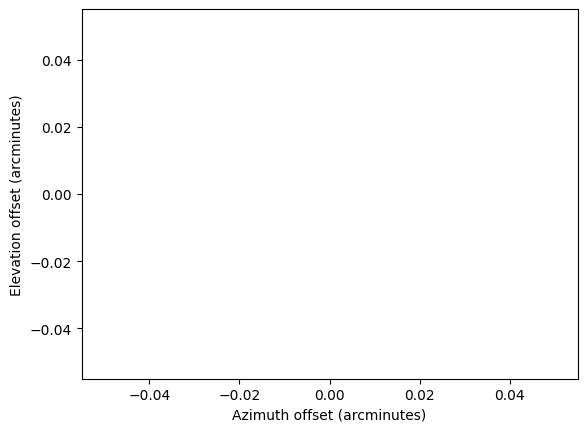

In [10]:
print(azel_offset.shape)

plt.scatter(azel_offset[:,0]*60., azel_offset[:,1]*60.)
plt.xlabel("Azimuth offset (arcminutes)")
plt.ylabel("Elevation offset (arcminutes)")